# Laboratory work №5

### Maslennikova Elizaveta, Shchegletova Tatyana 18IAD

In [1]:
import pandas as pd
import numpy as np
from pymystem3 import Mystem
from sklearn.feature_extraction.text import CountVectorizer
import re 
import nltk
import sys
nltk.download('stopwords')
from nltk.corpus import stopwords 
import matplotlib.pyplot as plt
import re
import collections
import torch
from torch import nn
import torch.nn.functional as F
import itertools
from torch.autograd import Variable
from torch.utils import data as dt
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/elizavetamaslennikova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import warnings
warnings.filterwarnings("ignore")

### Reading and light clearing data 

In [3]:
def tokenize(string):
    string = re.sub(r'\W', ' ',  string)
    string = re.sub(r'\s+', ' ', string, flags=re.I)
    tokens = re.findall(r'\b[А-Яа-я-]{1,}\b', string)
    sentance = ' '.join(tokens)
    return sentance

In [4]:
data = pd.read_json('final.json')
data.index = range(0, data.shape[0])
data.shape

(103132, 2)

In [5]:
data['clean_title'] = pd.Series()
for i in range(0, data.shape[0]):
    sentance = tokenize(data.loc[i]['title'])
    data.loc[i, 'clean_title'] = sentance
    if i % 5 == 0 or i == data.shape[0] - 1:
        sys.stdout.write("\r%f%%" % (100*(i+1)/data.shape[0]))
        sys.stdout.flush()
data.head(10)

100.000000%

,text,title,clean_title
0,"Телеведущая Ксения Собчак считает, что художе...","Серебренников создал не просто театр, а ""центр...",Серебренников создал не просто театр а центр с...
1,Интернет-сервис Amazo удалил с сайта объявлени...,"Американка сняла на видео ""профессиональный"" ф...",Американка сняла на видео профессиональный фен...
2,Посольство России в Вашингтоне готово оказать...,Посольство России призвало США прекратить похи...,Посольство России призвало США прекратить похи...
3,"В четверг стало известно, что российский боксе...",Тренер Гассиева: повторный бой с Лебедевым ста...,Тренер Гассиева повторный бой с Лебедевым стал...
4,Апелляционный суд Киева отпустил из-под арест...,Суд отпустил из-под ареста подозреваемых в под...,Суд отпустил из под ареста подозреваемых в под...
5,Информационный плакат о кандидатах в президен...,Данные о счетах Грудинина внесут в информацион...,Данные о счетах Грудинина внесут в информацион...
6,В Китае посетителям показали шесть детенышей ...,"В Китае сняли на видео, как работники зоопарка...",В Китае сняли на видео как работники зоопарка ...
7,. Сахалинский областной суд в понедельник пере...,Сахалинский суд отложил заседание по апелляции...,Сахалинский суд отложил заседание по апелляции...
8,Владимир Путин в начале своего президентства б...,Немецкий политик рассказал об ошибке Европы в ...,Немецкий политик рассказал об ошибке Европы в ...
9,. Россияне в феврале 2019 года увеличили свои ...,"""Ромир"": россияне в феврале вопреки традиции п...",Ромир россияне в феврале вопреки традиции повы...


### Get only titles, calculate maximum length of sentances and padding all titles to this length

**#** - end of the sentance, **&** - padding symbol

In [23]:
titles = data['clean_title'].tolist()
titles = titles[:32*3222]
titles[:10]

['Серебренников создал не просто театр а центр силы считает Собчак',
 'Американка сняла на видео профессиональный фен извергающий пламя',
 'Посольство России призвало США прекратить похищать россиян',
 'Тренер Гассиева повторный бой с Лебедевым стал бы войной Севера и Юга',
 'Суд отпустил из под ареста подозреваемых в поджоге часовни УПЦ МП в Киеве',
 'Данные о счетах Грудинина внесут в информационный плакат о кандидатах',
 'В Китае сняли на видео как работники зоопарка ухаживают за тигрятами',
 'Сахалинский суд отложил заседание по апелляции на приговор экс губернатору',
 'Немецкий политик рассказал об ошибке Европы в отношениях с Россией',
 'Ромир россияне в феврале вопреки традиции повысили повседневные траты']

In [24]:
X_lengths = [len(t) for t in titles]
max_len = max(X_lengths) + 1
print('Maximum length of sentances = ', max_len)

Maximum length of sentances =  97


In [25]:
titles = [t + "#" for t in titles]
titles = [t.ljust(max_len, '&') for t in titles]
titles[:10]

['Серебренников создал не просто театр а центр силы считает Собчак#&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&',
 'Американка сняла на видео профессиональный фен извергающий пламя#&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&',
 'Посольство России призвало США прекратить похищать россиян#&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&',
 'Тренер Гассиева повторный бой с Лебедевым стал бы войной Севера и Юга#&&&&&&&&&&&&&&&&&&&&&&&&&&&',
 'Суд отпустил из под ареста подозреваемых в поджоге часовни УПЦ МП в Киеве#&&&&&&&&&&&&&&&&&&&&&&&',
 'Данные о счетах Грудинина внесут в информационный плакат о кандидатах#&&&&&&&&&&&&&&&&&&&&&&&&&&&',
 'В Китае сняли на видео как работники зоопарка ухаживают за тигрятами#&&&&&&&&&&&&&&&&&&&&&&&&&&&&',
 'Сахалинский суд отложил заседание по апелляции на приговор экс губернатору#&&&&&&&&&&&&&&&&&&&&&&',
 'Немецкий политик рассказал об ошибке Европы в отношениях с Россией#&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&',
 'Ромир россияне в феврале вопреки традиции повысили повседневные траты#&&&&&&&&&&

### Create vocabulary 

**ind2token** - return token from vocalulary corresponding to the given index

**token2ind** - return index of corresponding token from vocalulary

In [26]:
ind2token = sorted(set(''.join(titles)))
token2ind = {}
for i in range(0, len(ind2token)):
    token2ind[ind2token[i]] = i
list(token2ind.items())[:10]

[(' ', 0),
 ('#', 1),
 ('&', 2),
 ('А', 3),
 ('Б', 4),
 ('В', 5),
 ('Г', 6),
 ('Д', 7),
 ('Е', 8),
 ('Ж', 9)]

In [27]:
ind2token[:10]

[' ', '#', '&', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж']

### Create X and Y tensors for training 

In [28]:
X = [[token2ind[t] for t in title[:-1]] for title in titles]
y = [[token2ind[t] for t in title[1:]] for title in titles]

In [29]:
X = torch.LongTensor(X)
X

tensor([[20, 40, 51,  ...,  2,  2,  2],
        [ 3, 47, 40,  ...,  2,  2,  2],
        [18, 49, 52,  ...,  2,  2,  2],
        ...,
        [22, 58, 35,  ...,  2,  2,  2],
        [ 9, 35, 47,  ...,  2,  2,  2],
        [50, 51, 43,  ...,  2,  2,  2]])

In [30]:
y = torch.LongTensor(y)
y

tensor([[40, 51, 40,  ...,  2,  2,  2],
        [47, 40, 51,  ...,  2,  2,  2],
        [49, 52, 49,  ...,  2,  2,  2],
        ...,
        [58, 35, 52,  ...,  2,  2,  2],
        [35, 47, 36,  ...,  2,  2,  2],
        [51, 43, 49,  ...,  2,  2,  2]])

#### Also need to remember length of input sentences

In [31]:
X_lengths = torch.IntTensor(X_lengths)
X_lengths

tensor([64, 64, 58,  ..., 75, 71, 33], dtype=torch.int32)

In [32]:
print(X.size(), y.size(), X_lengths.size())

torch.Size([103104, 96]) torch.Size([103104, 96]) torch.Size([103104])


#### Create loader for data by batch

In [33]:
torch_dataset = dt.TensorDataset(X, y, X_lengths)
loader = dt.DataLoader(dataset=torch_dataset, batch_size=16, shuffle=True)

### Define the network

In [34]:
class BieberLSTM(nn.Module):
    def __init__(self, token2ind, ind2token, n_layers = 2, n_lstm_units=100, embedding_dim=1024, batch_size=16):
        super(BieberLSTM, self).__init__()
        self.token2ind = token2ind
        self.ind2token = ind2token

        self.n_lstm_layers = n_layers
        self.n_lstm_units = n_lstm_units
        self.embedding_dim = embedding_dim
        self.batch_size = batch_size
        self.n_vocab = len(self.ind2token)
        self.lstm = None

        # build actual NN
        self.__build_model()
        
    def __build_model(self):
        # Embedding layer
        # Embedding vector for padding index will be zero vector
        self.word_embedding = nn.Embedding(num_embeddings=self.n_vocab,
                embedding_dim=self.embedding_dim, padding_idx=self.token2ind['&'])

        # LSTM
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.n_lstm_units,
                            num_layers=self.n_lstm_layers, batch_first=True)

        # Linear output layer
        self.hidden_to_next = nn.Linear(self.n_lstm_units, self.n_vocab)
    
    def init_hidden(self, test=False):
        # The shape of weights - (nb_layers, batch_size, nb_lstm_units)
        if test:
            self.batch_size = 1
        hidden_a = torch.randn(self.n_lstm_layers, self.batch_size, self.n_lstm_units)
        hidden_b = torch.randn(self.n_lstm_layers, self.batch_size, self.n_lstm_units)

        hidden_a = Variable(hidden_a)
        hidden_b = Variable(hidden_b)

        return (hidden_a, hidden_b)

    def forward(self, X, X_lengths, test=False):
        self.hidden = self.init_hidden(test)
        batch_size, seq_len = X.size()

        # Embed the input: (batch_size, seq_len, 1) -> (batch_size, seq_len, embedding_dim)
        X = self.word_embedding(X)
        
        # LSTM with padding: (batch_size, seq_len, embedding_dim) -> (batch_size, seq_len, n_lstm_units)

        # Function 'pack_padded_sequence' helps not to take into account padded items in the sequence in the LSTM
        X = torch.nn.utils.rnn.pack_padded_sequence(X, X_lengths, batch_first=True)
        X, self.hidden = self.lstm(X, self.hidden)
        X, _ = torch.nn.utils.rnn.pad_packed_sequence(X, batch_first=True, total_length=seq_len)

        # Linear layer: (batch_size, seq_len, n_lstm_units) -> (batch_size * seq_len, n_lstm_units)
        X = X.contiguous()
        X = X.view(-1, X.shape[2])
        X = self.hidden_to_next(X)
        
        # Softmax activation: (batch_size * seq_len, n_lstm_units) -> (batch_size, seq_len, n_vocab)
        X = F.log_softmax(X, dim=1)
        X = X.view(batch_size, seq_len, self.n_vocab)
        return X
    
    
    def loss(self, Y_pred, Y, X_lengths):
        Y = Y.view(-1)
        Y_pred = Y_pred.view(-1, self.n_vocab)

        # Create a mask by filtering out all tokens that ARE NOT the padding token
        ind_pad_token = self.token2ind['&']
        mask = (Y != ind_pad_token).float()
        n_tokens = int(torch.sum(mask).data)
        
        # Apply mask for calculate cross entropy loss which ignores all padding tokens
        Y_pred = Y_pred[range(Y_pred.shape[0]), Y] * mask
        loss_val = -torch.sum(Y_pred) / n_tokens
        return loss_val

In [35]:
model = BieberLSTM(token2ind, ind2token)
print(model)

BieberLSTM(
  (word_embedding): Embedding(67, 1024, padding_idx=2)
  (lstm): LSTM(1024, 100, num_layers=2, batch_first=True)
  (hidden_to_next): Linear(in_features=100, out_features=67, bias=True)
)


In [36]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
# criterion = model.loss
criterion = nn.CrossEntropyLoss(ignore_index=token2ind['&'])

In [37]:
def batch_sort(batch_x, batch_y, lehgths):
    # function for sorting batches by decreasing length of sentances
    lengths_new, indexes = torch.sort(lehgths, descending=True)
    batch_x_new = batch_x[indexes]
    batch_y_new = batch_y[indexes]
    
    return batch_x_new, batch_y_new, lengths_new

In [38]:
def train(model, opt, criterion, init_epochs, epochs, loader,log_interval=1):
    loss_value = []
    for epoch in range(init_epochs, epochs):
        for step, (batch_x, batch_y, lengths) in enumerate(loader):
            batch_x, batch_y, lengths = batch_sort(batch_x, batch_y, lengths)
            lengths = lengths.tolist()
            opt.zero_grad()
            model_out = model(batch_x, lengths)
            model_out = model_out.view(-1, model_out.size()[2])
            batch_y = batch_y.view(batch_y.size()[0]*batch_y.size()[1])
            loss = criterion(model_out, batch_y)
            loss.backward()
            opt.step()
            if step % log_interval == 0:
                sys.stdout.write("\r%f%%" % (step*100/len(loader)))
                sys.stdout.flush()
        sys.stdout.write("\r%f%%" % (100))
        print('\nTrain Epoch: {} \tLoss: {:.6f}\n'.format(epoch,loss.data))
        loss_value.append(loss.data)
        sys.stdout.flush()
    return model, loss_value

In [39]:
init_epoch = 0
epochs = 5
model, loss_value = train(model, opt, criterion, init_epoch, epochs, loader)

100.000000%
Train Epoch: 0 	Loss: 1.602666

100.000000%
Train Epoch: 1 	Loss: 1.585231

100.000000%
Train Epoch: 2 	Loss: 1.455148

100.000000%
Train Epoch: 3 	Loss: 1.504956

100.000000%
Train Epoch: 4 	Loss: 1.378352



In [ ]:
loss_value = [i.numpy() for i in loss_value]

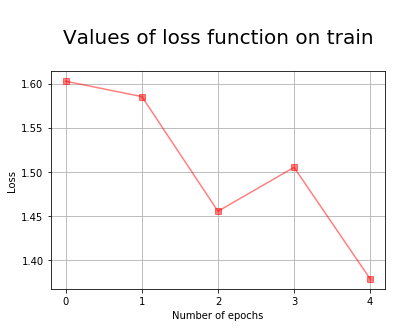

In [74]:
# plt.figure(figsize = (15, 10))
ep = [i for i in range(0, epochs)]
plt.plot(ep, loss_value, color = 'r', marker = "s", alpha=0.5)

# plt.plot(n_estim, [1-i for i in grid.cv_results_["mean_train_score"]], "b-o", alpha=0.7)

# plt.scatter(grid.best_params_['n_estimators'], 1 - grid.best_score_, color = "g", s=200)

plt.xticks(ep)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('\nValues of loss function on train\n', fontdict={"fontsize":20})
plt.grid(b=True)

In [42]:
def predict_sentance(string, model):
    string = [s for s in string]
    token = ''
    while token != '#':
        X_test = np.array([[model.token2ind[t] for t in string]])
        X_test = torch.from_numpy(X_test)
        model_out = model(X_test, [len(X_test[0])], test=True)
        token = model.ind2token[torch.max(model_out[0][-1], 0)[1].item()]
        string.append(token)
        sys.stdout.write('\r%s' % ''.join(string))
        sys.stdout.flush()
    return ''.join(string)

In [43]:
begin = 'С'
sentance = predict_sentance(begin, model)

Суд получил проведение после пострадавших в полуфинале мира в Казани#

In [52]:
begin = 'В'
sentance = predict_sentance(begin, model)

В Москве построит состав пострадавших в полуфинале мира в Китае#

In [57]:
begin = 'Сири'
sentance = predict_sentance(begin, model)

Сирийский призвал политики в полуфинале мира в Китае#

In [514]:
begin = 'П'
sentance = predict_sentance(begin, model)

Политолог обыграл США по делу о полуфинале Кубка мира в Сирии#